# Speech Emotion Detection

Submitted by: Neethu Ignacious, Pooja Patel, Sanjana Bale, Suryansh Bali
    
Dataset Information

Each of the 1440 files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 03-01-06-01-02-01-12.wav). 
These identifiers define the stimulus characteristics:

Filename identifiers

Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
Vocal channel (01 = speech, 02 = song).
Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
Emotional intensity (01 = normal, 02 = strong). 
Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
Repetition (01 = 1st repetition, 02 = 2nd repetition).
Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Dataset URL: https://www.kaggle.com/uwrfkaggler/ravdess-emotional-speech-audio
        
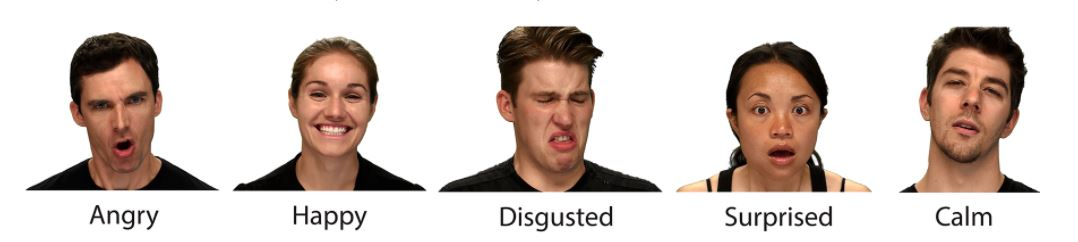

## Package installation

In [1]:
#installing required packages
!pip install python_speech_features
!pip install librosa
!pip install noisereduce


## Importing libraries

In [34]:
#Install all the Reqiuired Libraries

#Data analysis and exploration libraries
import numpy as np
import pandas as pd

#Data Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from tqdm import tqdm
from scipy.io import wavfile
from python_speech_features import mfcc,logfbank
import librosa as lr
import os, glob, pickle

from scipy import signal
import noisereduce as nr
import soundfile

#Splitting data library
from sklearn.model_selection import train_test_split

#Feature scaling library
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#Model building libraries
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

#Cross validation library
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#Performance evaluation library
from sklearn.metrics import confusion_matrix,classification_report

## Extracting RAVDESS Data

In [3]:
from zipfile import ZipFile
zf = ZipFile('Data.zip', 'r')
zf.extractall('RAVDESS_Data')
zf.close()

## Loading the dataset

In [35]:
os.listdir(path='.\RAVDESS_Data')

def getfile(directory):
    
    file_list = os.listdir(directory)
    files = list()
    
    for i in file_list:
        file_path = os.path.join(directory, i)
        
        if os.path.isdir(file_path):
            files = files + getfile(file_path)
            
        else:
            files.append(file_path)
    
    return files

directory = './RAVDESS_Data'

data = getfile(directory)


## Data Cleaning

In [36]:
def sampling(s,r,t):
    
    masking = []
    s = pd.Series(s).apply(np.abs)
    smean = s.rolling(window = int(r/10) , min_periods=1 , center = True).mean()
    
    for m in smean:
        if m > t:
            masking.append(True)
        else:
            masking.append(False)
    
    return masking

## Saving the cleaned data

In [6]:
for f in tqdm(glob.glob(r'RAVDESS_Data\\**\\*.wav')):
    
    f_name = os.path.basename(f)
    #Load an audio file as a floating point time series and resample to 16 KHz
    sig, rt = lr.load(f, sr=16000)
    th = 0.0005
    masking = sampling(sig,rt,th)
    
    wavfile.write(filename= r'Cleaned_Data\\'+str(f_name), rate = rt, data = sig[masking])

100%|██████████████████████████████████████████████████████████████████████████████| 1440/1440 [10:24<00:00,  2.31it/s]


## Feature Extraction

In [37]:
def feature_extraction(file):
    
    X, sample_rate = lr.load(file)
    stft = np.abs(lr.stft(X))
    result = np.array([])
    mfccs = np.mean(lr.feature.mfcc(y = X, sr = sample_rate, n_mfcc = 40).T,axis = 0)
    result = np.hstack((result, mfccs))
    chroma = np.mean(lr.feature.chroma_stft(S = stft, sr = sample_rate).T,axis = 0)
    result = np.hstack((result, chroma))
    mel = np.mean(lr.feature.melspectrogram(X, sr = sample_rate).T,axis=0)
    result = np.hstack((result, mel))
    
    return result

## Emotions in RAVDESS Dataset

In [38]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}


## Loading the data

In [39]:
def data_loading(test_size=0.2):
    
    x = []
    y = []
    
    for i in glob.glob(r'Cleaned_Data\\*.wav'):
        
        f_name = os.path.basename(i)
        emotion = emotions[f_name.split("-")[2]]
        feature = feature_extraction(i)
        x.append(feature)
        y.append(emotion)
        
    return train_test_split(np.array(x), y, test_size = test_size, random_state=1)

## Data Splitting

In [154]:
X_train, X_test, y_train, y_test = data_loading()

## Non optimized SVM model

In [41]:
non_opt_svm = SVC()
non_opt_svm.fit(X_train, y_train)

SVC()

In [42]:
non_opt_svm_pred = non_opt_svm.predict(X_test)

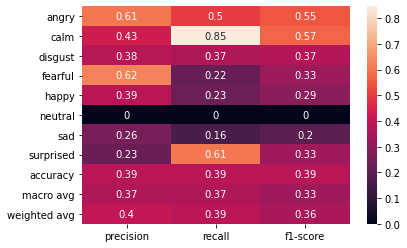

In [44]:
non_opt_svm_pred_report = classification_report(y_test,non_opt_svm_pred,output_dict=True);
sns.heatmap(pd.DataFrame(non_opt_svm_pred_report).iloc[:-1, :].T, annot=True);

In [45]:
print("Accuracy of training dataset of Non optimized/non scaled SVM model:",non_opt_svm.score(X_train, y_train))
print("Accuracy of testing dataset Non optimized/non scaled SVM model:",non_opt_svm.score(X_test, y_test))

Accuracy of training dataset of Non optimized/non scaled SVM model: 0.3845486111111111
Accuracy of testing dataset Non optimized/non scaled SVM model: 0.3854166666666667


## SVM model with MinMax Scaling

In [47]:
minmax_scaler = MinMaxScaler()
X_train = minmax_scaler.fit_transform(X_train)
X_test = minmax_scaler.transform(X_test)

In [48]:
minmax_scale_svm = SVC()
minmax_scale_svm.fit(X_train, y_train)

SVC()

In [49]:
minmax_scale_svm_pred = minmax_scale_svm.predict(X_test)

C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


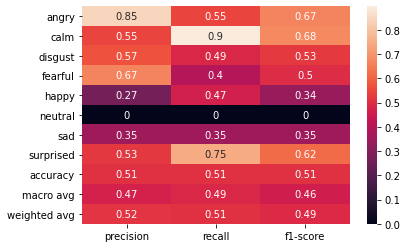

In [50]:
minmax_scale_svm_pred_report = classification_report(y_test,minmax_scale_svm_pred,output_dict=True);
sns.heatmap(pd.DataFrame(minmax_scale_svm_pred_report).iloc[:-1, :].T, annot=True);

In [51]:
print("Accuracy of training dataset of MinMax scaled SVM model:",minmax_scale_svm.score(X_train, y_train))
print("Accuracy of testing dataset of MinMax scaled SVM model:",minmax_scale_svm.score(X_test, y_test))

Accuracy of training dataset of MinMax scaled SVM model: 0.5685763888888888
Accuracy of testing dataset of MinMax scaled SVM model: 0.5104166666666666


In [53]:
std_scaler_svm = StandardScaler()
X_train = std_scaler_svm.fit_transform(X_train)
X_test = std_scaler_svm.transform(X_test)

In [54]:
std_scaler_svm = SVC()
std_scaler_svm.fit(X_train, y_train)

SVC()

In [55]:
std_scaler_svm_pred = std_scaler_svm.predict(X_test)

C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


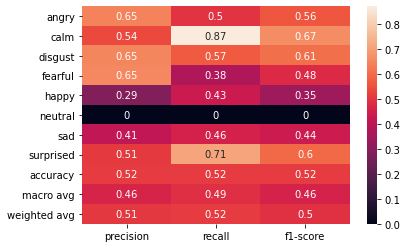

In [56]:
std_scaler_svm_pred_report = classification_report(y_test,std_scaler_svm_pred,output_dict=True);
sns.heatmap(pd.DataFrame(std_scaler_svm_pred_report).iloc[:-1, :].T, annot=True);

In [57]:
print("Accuracy of training dataset of Standard scalar SVM model:",std_scaler_svm.score(X_train, y_train))
print("Accuracy of testing dataset of Standard Scalar SVM model:",std_scaler_svm.score(X_test, y_test))

Accuracy of training dataset of Standard scalar SVM model: 0.6571180555555556
Accuracy of testing dataset of Standard Scalar SVM model: 0.5173611111111112


## Non optimised MLP classifier

In [84]:
non_opt_mlp = MLPClassifier()
non_opt_mlp.fit(X_train, y_train)

C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [85]:
non_opt_mlp_pred = non_opt_mlp.predict(X_test)

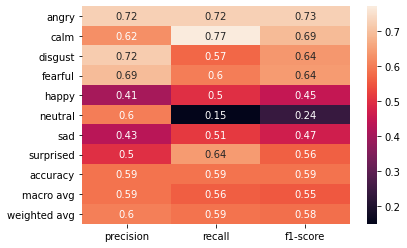

In [86]:
non_opt_mlp_pred_report = classification_report(y_test,non_opt_mlp_pred,output_dict=True);
sns.heatmap(pd.DataFrame(non_opt_mlp_pred_report).iloc[:-1, :].T, annot=True);

In [87]:
print("Accuracy of training dataset of Non optimized/non scaled MLP model:",non_opt_mlp.score(X_train, y_train))
print("Accuracy of testing dataset Non optimized/non scaled MLP model:",non_opt_mlp.score(X_test, y_test))

Accuracy of training dataset of Non optimized/non scaled MLP model: 0.7230902777777778
Accuracy of testing dataset Non optimized/non scaled MLP model: 0.5868055555555556


## MLP with MinMax Scalar

In [88]:
minmax_scaler = MinMaxScaler()
X_train = minmax_scaler.fit_transform(X_train)
X_test = minmax_scaler.transform(X_test)

In [89]:
minmax_scale_mlp = MLPClassifier()
minmax_scale_mlp.fit(X_train, y_train)

C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [90]:
minmax_scale_mlp_pred = minmax_scale_mlp.predict(X_test)

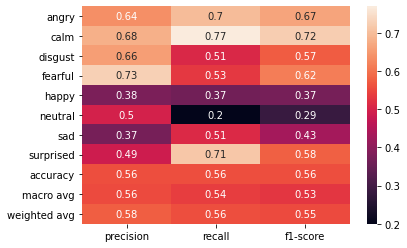

In [91]:
minmax_scale_mlp_pred_report = classification_report(y_test,minmax_scale_mlp_pred,output_dict=True);
sns.heatmap(pd.DataFrame(minmax_scale_mlp_pred_report).iloc[:-1, :].T, annot=True);

In [92]:
print("Accuracy of training dataset of MinMax scaled MLP model:",minmax_scale_mlp.score(X_train, y_train))
print("Accuracy of testing dataset of MinMax scaled MLP model:",minmax_scale_mlp.score(X_test, y_test))

Accuracy of training dataset of MinMax scaled MLP model: 0.7161458333333334
Accuracy of testing dataset of MinMax scaled MLP model: 0.5590277777777778


## MLP with Standard Scalar

In [93]:
std_scaler_mlp = StandardScaler()
X_train = std_scaler_mlp.fit_transform(X_train)
X_test = std_scaler_mlp.transform(X_test)

In [94]:
std_scaler_mlp = MLPClassifier()
std_scaler_mlp.fit(X_train, y_train)

C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier()

In [95]:
std_scaler_mlp_pred = std_scaler_mlp.predict(X_test)

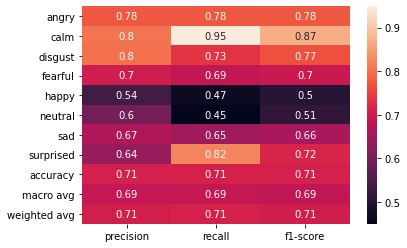

In [96]:
std_scaler_mlp_pred_report = classification_report(y_test,std_scaler_mlp_pred,output_dict=True);
sns.heatmap(pd.DataFrame(std_scaler_mlp_pred_report).iloc[:-1, :].T, annot=True);

In [98]:
print("Accuracy of training dataset of Standard scalar MLP model:",std_scaler_mlp.score(X_train, y_train))
print("Accuracy of testing dataset of Standard Scalar MLP model:",std_scaler_mlp.score(X_test, y_test))

Accuracy of training dataset of Standard scalar MLP model: 0.9973958333333334
Accuracy of testing dataset of Standard Scalar MLP model: 0.7118055555555556


## Model Building

### SVM Model

In [59]:
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [64]:
#Finding the grid parameters
param_grid = {'C':[0.01,0.1,1, 10, 100, 1000],'gamma':[1,0.1,0.01,0.001,0.0001],'kernel':['rbf','poly','sigmoid'],
            'shrinking':[True,False]} 
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3);
grid.fit(X_train,y_train)
print(grid.best_params_)


Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] C=0.01, gamma=1, kernel=rbf, shrinking=True .....................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=0.01, gamma=1, kernel=rbf, shrinking=True, score=0.143, total=   0.9s
[CV] C=0.01, gamma=1, kernel=rbf, shrinking=True .....................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV]  C=0.01, gamma=1, kernel=rbf, shrinking=True, score=0.139, total=   0.9s
[CV] C=0.01, gamma=1, kernel=rbf, shrinking=True .....................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.7s remaining:    0.0s


[CV]  C=0.01, gamma=1, kernel=rbf, shrinking=True, score=0.143, total=   0.9s
[CV] C=0.01, gamma=1, kernel=rbf, shrinking=True .....................
[CV]  C=0.01, gamma=1, kernel=rbf, shrinking=True, score=0.143, total=   1.0s
[CV] C=0.01, gamma=1, kernel=rbf, shrinking=True .....................
[CV]  C=0.01, gamma=1, kernel=rbf, shrinking=True, score=0.143, total=   0.9s
[CV] C=0.01, gamma=1, kernel=rbf, shrinking=False ....................
[CV]  C=0.01, gamma=1, kernel=rbf, shrinking=False, score=0.143, total=   0.9s
[CV] C=0.01, gamma=1, kernel=rbf, shrinking=False ....................
[CV]  C=0.01, gamma=1, kernel=rbf, shrinking=False, score=0.139, total=   0.9s
[CV] C=0.01, gamma=1, kernel=rbf, shrinking=False ....................
[CV]  C=0.01, gamma=1, kernel=rbf, shrinking=False, score=0.143, total=   0.9s
[CV] C=0.01, gamma=1, kernel=rbf, shrinking=False ....................
[CV]  C=0.01, gamma=1, kernel=rbf, shrinking=False, score=0.143, total=   1.2s
[CV] C=0.01, gamma=1, ke

[Parallel(n_jobs=1)]: Done 900 out of 900 | elapsed: 11.4min finished


{'C': 10, 'gamma': 0.01, 'kernel': 'rbf', 'shrinking': True}


In [74]:
#SVM Model

classifier = SVC(C = 10 , gamma = 0.01, kernel = 'rbf')
classifier.fit(X_train, y_train)

SVC(C=10, gamma=0.01)

In [75]:
# Predicting the Test and Train set results

y_pred = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)
cm_test = confusion_matrix(y_pred, y_test)
print("\nConfusion matrix of Train Data\n")
print(cm_train)
print("\nConfusion matrix of Test Data\n")
print(cm_test)


Confusion matrix of Train Data

[[149   0   1   0   0   0   0   0]
 [  0 152   0   0   0   1   1   0]
 [  2   0 142   0   0   0   0   1]
 [  0   0   0 146   0   0   0   0]
 [  0   0   0   0 159   0   0   0]
 [  0   0   0   0   0  72   1   0]
 [  0   1   0   1   3   3 153   1]
 [  1   0   0   0   0   0   0 162]]

Confusion matrix of Test Data

[[31  0  4  7  3  1  1  2]
 [ 0 36  2  2  0  5  3  0]
 [ 1  1 37  3  1  0  1  1]
 [ 4  1  1 24  3  0  2  0]
 [ 2  0  1  5 16  2  3  2]
 [ 1  0  1  0  1 10  1  0]
 [ 0  1  1  3  3  1 26  0]
 [ 1  0  2  1  3  1  0 23]]


In [76]:
#accuracy of train and test dataset

print("Accuracy of training dataset:",classifier.score(X_train, y_train))
print("Accuracy of testing dataset:",classifier.score(X_test, y_test))

Accuracy of training dataset: 0.9852430555555556
Accuracy of testing dataset: 0.7048611111111112


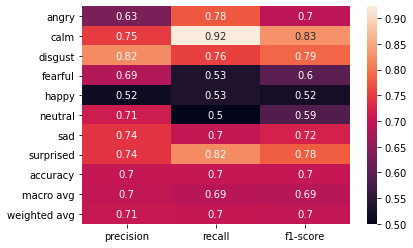

In [68]:
#Classification report of Support Vector Machine Model

clf_report = classification_report(y_test,y_pred,output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

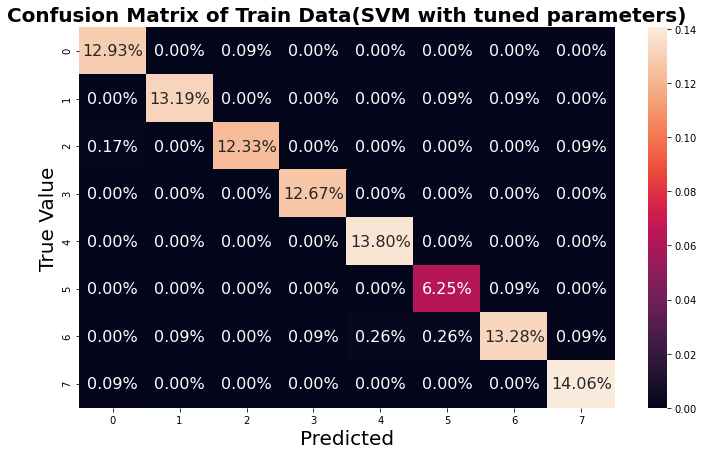

In [69]:
#Visualizing the confusion matrix of SVM model in training dataset

plt.figure(figsize=(12, 7))
sns.heatmap(cm_train/np.sum(cm_train), annot=True,fmt='.2%',annot_kws={"size": 16})
plt.title("Confusion Matrix of Train Data(SVM with tuned parameters)",size='20',weight='bold')
plt.xlabel("Predicted",size='20')
plt.ylabel("True Value",size='20')
plt.show()

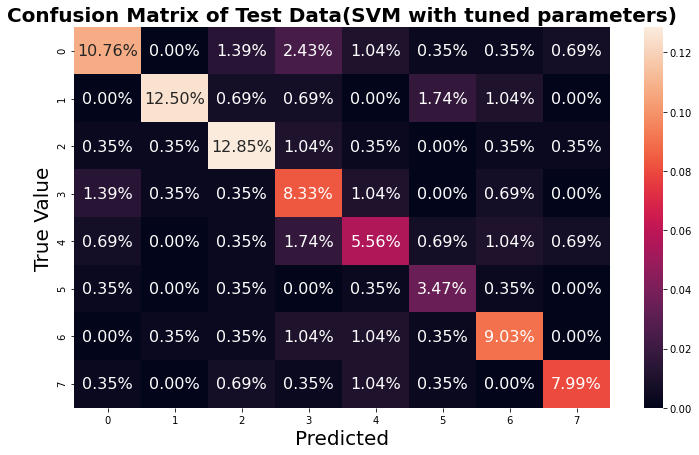

In [70]:
#Visualizing the confusion matrix of SVM model in test dataset

plt.figure(figsize=(12, 7))
sns.heatmap(cm_test/np.sum(cm_test), annot=True,fmt='.2%',annot_kws={"size": 16})
plt.title("Confusion Matrix of Test Data(SVM with tuned parameters)",size='20',weight='bold')
plt.xlabel("Predicted",size='20')
plt.ylabel("True Value",size='20')
plt.show()

### MLP Classifier

In [155]:
scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

In [139]:
#Finding the grid parameters
param_grid = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,50)],'activation': ['tanh', 'relu'],
              'solver': ['sgd', 'adam'],'alpha': [0.01, 0.0001, 0.05],'learning_rate': ['constant','adaptive']}
grid = GridSearchCV(MLPClassifier(),param_grid,refit=True,verbose=3);
grid.fit(X_train,y_train)
print(grid.best_params_)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.433, total=   6.7s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.7s remaining:    0.0s


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.472, total=   7.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.530, total=   7.7s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.504, total=   6.8s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.509, total=   6.5s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.589, total=   6.6s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.558, total=   7.2s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.578, total=   7.2s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.600, total=   7.1s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.557, total=   6.5s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 
[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.489, total=   6.7s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.502, total=   5.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.530, total=   5.1s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.491, total=   5.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.504, total=   5.5s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.554, total=   6.2s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.597, total=   6.9s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.561, total=   7.5s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.604, total=   7.7s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.557, total=   7.7s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.485, total=   8.5s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.498, total=   7.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.513, total=   6.9s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.517, total=   6.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.522, total=   6.2s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.550, total=   9.1s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.584, total=   8.8s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.565, total=   9.6s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.578, total=   9.1s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.526, total=  11.7s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.476, total=   7.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.485, total=   6.6s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.500, total=   6.5s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.504, total=   7.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.530, total=   7.9s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.567, total=   9.4s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.636, total=  10.7s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.591, total=   7.8s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.574, total=   7.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.539, total=   6.9s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.472, total=   6.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.494, total=   6.5s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.509, total=   8.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.517, total=   7.2s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.517, total=   6.8s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.576, total=   7.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.619, total=   6.3s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.596, total=   6.7s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.630, total=   8.1s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.526, total=   7.8s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.485, total=   7.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.511, total=   7.5s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.474, total=   7.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.522, total=   6.5s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.526, total=   6.0s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.571, total=   6.1s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.606, total=   5.9s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.596, total=   6.4s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.557, total=   7.2s
[CV] activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.583, total=   8.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.485, total=   7.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.476, total=   6.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.526, total=   7.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.526, total=   6.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.509, total=   5.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.563, total=   6.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.593, total=   7.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.596, total=   8.9s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.535, total=   7.8s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.530, total=   8.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.489, total=   5.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.494, total=   5.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.474, total=   5.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.496, total=   5.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.513, total=   6.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.519, total=   7.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.597, total=   7.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.574, total=   8.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.591, total=   7.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.587, total=   6.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.476, total=   7.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.481, total=   7.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.513, total=   6.8s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.474, total=   7.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.522, total=   8.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.571, total=   9.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.593, total=   7.8s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.600, total=   9.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.587, total=   7.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.561, total=   8.8s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.485, total=   8.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.502, total=   7.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.491, total=   6.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.496, total=   7.8s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.535, total=   6.3s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.532, total=   8.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.602, total=   8.8s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.600, total=   8.9s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.630, total=  10.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.526, total=   9.8s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.450, total=   8.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.463, total=   6.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.522, total=   5.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.543, total=   5.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.539, total=   6.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.619, total=   7.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.584, total=   9.5s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.591, total=   7.9s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.609, total=   9.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.609, total=   8.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.494, total=   7.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.511, total=   9.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.509, total=   7.2s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.526, total=   9.1s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.543, total=   8.6s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.584, total=   7.9s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.606, total=   6.7s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.604, total=   6.4s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.609, total=   7.0s
[CV] activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.570, total=   7.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.446, total=   6.8s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.455, total=   6.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.535, total=   7.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.513, total=   6.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.500, total=   6.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.558, total=   7.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.602, total=   7.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.552, total=   7.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.622, total=   8.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.587, total=   8.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.468, total=   8.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.502, total=   8.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.509, total=   7.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.500, total=   7.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.530, total=   7.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.593, total=   7.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.597, total=   7.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.583, total=   6.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.570, total=   7.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.565, total=   8.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.446, total=   9.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.524, total=  10.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.504, total=  10.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.513, total=   8.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.504, total=   7.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.554, total=   9.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.597, total=   8.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.578, total=  11.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.557, total=  10.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.522, total=   8.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.502, total=   6.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.506, total=   6.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.491, total=   6.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.483, total=   7.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.500, total=   7.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.597, total=   9.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.597, total=   9.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.552, total=   8.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.543, total=   8.4s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.561, total=   7.6s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.494, total=   6.8s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.498, total=   6.8s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.526, total=   7.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.513, total=   7.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.561, total=   6.8s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.571, total=   7.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.597, total=   8.8s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.587, total=   7.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.587, total=   6.7s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.578, total=   7.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.476, total=   7.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.494, total=   7.8s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.526, total=   7.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.552, total=   6.2s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.535, total=   6.0s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.576, total=   6.5s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.623, total=   7.3s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.635, total=   8.9s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.630, total=   8.1s
[CV] activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=tanh, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.570, total=   7.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.433, total=  10.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.442, total=   6.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.496, total=   6.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.491, total=   7.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.448, total=   8.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.589, total=   8.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.619, total=   7.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.613, total=   7.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.609, total=   7.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.596, total=   8.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.424, total=   8.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.450, total=   8.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.470, total=  15.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.443, total=   7.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.465, total=   7.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.567, total=   8.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.632, total=   8.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.561, total=  11.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.552, total=   8.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.591, total=   8.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.429, total=   8.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.446, total=   8.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.470, total=   9.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.478, total=  10.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.448, total=   9.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.584, total=  11.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.602, total=   9.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.583, total=   9.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_s

C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.398, total=   9.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.416, total=   9.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.517, total=   7.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.474, total=   9.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.409, total=  10.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.593, total=   9.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.593, total=   9.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.600, total=  11.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.01, hidden_layer_s

C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.494, total=   6.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.506, total=   8.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.474, total=   9.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.474, total=  10.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.509, total=   7.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.619, total=   7.3s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.641, total=   8.5s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.578, total=   9.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.613, total=   8.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.604, total=   8.7s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.455, total=   7.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.519, total=   8.8s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.530, total=   7.9s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.526, total=   8.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.478, total=   8.1s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.589, total=   8.2s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.623, total=   7.4s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.604, total=   7.0s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.609, total=   8.6s
[CV] activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.01, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.600, total=   9.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.411, total=   8.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.407, total=   8.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.443, total=   8.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.435, total=   7.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.430, total=   8.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.580, total=   9.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.584, total=   8.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.600, total=   7.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.635, total=   8.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.578, total=   8.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.429, total=  11.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.381, total=   8.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.443, total=   7.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.465, total=   9.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.513, total=   7.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.571, total=   7.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.584, total=   7.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.596, total=   8.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.639, total=   8.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.643, total=   8.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.390, total=  10.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.411, total=   9.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.443, total=   8.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.457, total=   9.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.435, total=  10.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.571, total=  14.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.636, total=   9.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.583, total=   9.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.604, total=   9.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.0

C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.455, total=   9.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.481, total=   9.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.478, total=   9.2s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.483, total=   9.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.443, total=   8.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.610, total=   9.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.597, total=   9.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.626, total=  10.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 
[CV]  activation=relu, alpha=0.00

C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.472, total=   6.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.481, total=   7.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.470, total=   8.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.504, total=   8.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.461, total=   8.5s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.632, total=   9.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.628, total=   8.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.630, total=   7.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.587, total=   7.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.613, total=   7.9s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.476, total=  10.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.472, total=  10.4s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.517, total=   9.3s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.504, total=   9.8s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.500, total=   9.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.597, total=   9.7s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.628, total=   9.1s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.639, total=   8.6s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.630, total=   8.0s
[CV] activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.609, total=   7.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.433, total=   6.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.429, total=   7.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.465, total=   8.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.457, total=   8.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=sgd, score=0.448, total=  10.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.606, total=  13.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.563, total=   8.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.596, total=   8.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.570, total=   8.9s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=constant, solver=adam, score=0.578, total=   8.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.468, total=   7.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.446, total=   9.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.435, total=   9.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.457, total=  10.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=sgd, score=0.413, total=   7.9s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.563, total=   7.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.610, total=   7.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.622, total=   7.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.578, total=  12.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 50, 50), learning_rate=adaptive, solver=adam, score=0.583, total=  10.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.463, total=  11.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.437, total=  11.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.474, total=  11.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.461, total=   9.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=sgd, score=0.439, total=  10.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.606, total=  10.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.610, total=  11.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.591, total=  11.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 
[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.639, total=  25.9s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=constant, solver=adam, score=0.604, total=  11.5s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.403, total=  10.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.459, total=  10.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.478, total=  10.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.470, total=  10.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=sgd, score=0.422, total=  11.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.597, total=  13.9s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.610, total=  12.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.578, total=   8.3s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.657, total=   9.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(50, 100, 50), learning_rate=adaptive, solver=adam, score=0.570, total=   9.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.455, total=   8.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.450, total=   8.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.491, total=   8.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.500, total=  11.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd, score=0.461, total=  10.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.580, total=  11.7s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.636, total=   9.9s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.630, total=  10.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.617, total=   9.1s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam, score=0.600, total=   8.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.481, total=   8.6s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.472, total=   7.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.517, total=   7.0s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.443, total=   6.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd, score=0.500, total=   6.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.584, total=   7.8s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.628, total=   8.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.604, total=   8.2s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.604, total=   8.4s
[CV] activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam 


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 50.0min finished


[CV]  activation=relu, alpha=0.05, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam, score=0.596, total=   9.0s
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}


C:\Users\Neethu\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [156]:
#MultiLinearPerceptron Classifier
model = MLPClassifier(alpha=0.0001, batch_size=350,epsilon=1e-08, hidden_layer_sizes=(500,100), 
                      learning_rate='constant', activation = 'relu',solver = 'adam',max_iter=500)
model.fit(X_train,y_train)

MLPClassifier(batch_size=350, hidden_layer_sizes=(500, 100), max_iter=500)

In [157]:
# Predicting the Test and Train set results

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)
cm_test = confusion_matrix(y_pred, y_test)
print("\nConfusion matrix of Train Data\n")
print(cm_train)
print("\nConfusion matrix of Test Data\n")
print(cm_test)


Confusion matrix of Train Data

[[152   0   0   0   0   0   0   0]
 [  0 153   0   0   0   0   0   0]
 [  0   0 143   0   0   0   0   0]
 [  0   0   0 147   0   0   0   0]
 [  0   0   0   0 162   0   0   0]
 [  0   0   0   0   0  76   0   0]
 [  0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0 164]]

Confusion matrix of Test Data

[[28  0  3  0  1  0  0  1]
 [ 0 36  1  1  0  6  1  0]
 [ 3  0 39  2  2  1  1  0]
 [ 3  1  1 29  4  0  2  1]
 [ 2  0  1  3 17  2  4  3]
 [ 1  1  0  0  2  9  3  0]
 [ 1  1  2  8  2  2 26  0]
 [ 2  0  2  2  2  0  0 23]]


In [158]:
#accuracy of train and test dataset

print("Accuracy of training dataset:",model.score(X_train, y_train))
print("Accuracy of testing dataset:",model.score(X_test, y_test))

Accuracy of training dataset: 1.0
Accuracy of testing dataset: 0.71875


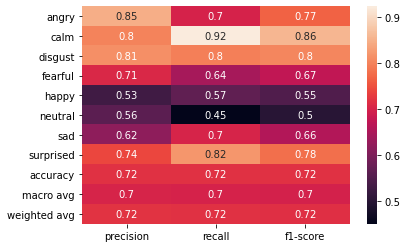

In [159]:
clf_report = classification_report(y_test,y_pred,output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

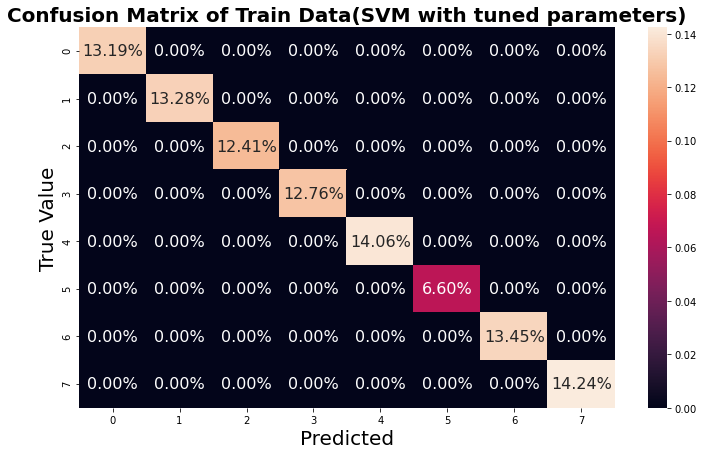

In [160]:
#Visualizing the confusion matrix of SVM model in training dataset

plt.figure(figsize=(12, 7))
sns.heatmap(cm_train/np.sum(cm_train), fmt='.2%',annot=True,annot_kws={"size": 16})
plt.title("Confusion Matrix of Train Data(SVM with tuned parameters)",size='20',weight='bold')
plt.xlabel("Predicted",size='20')
plt.ylabel("True Value",size='20')
plt.show()

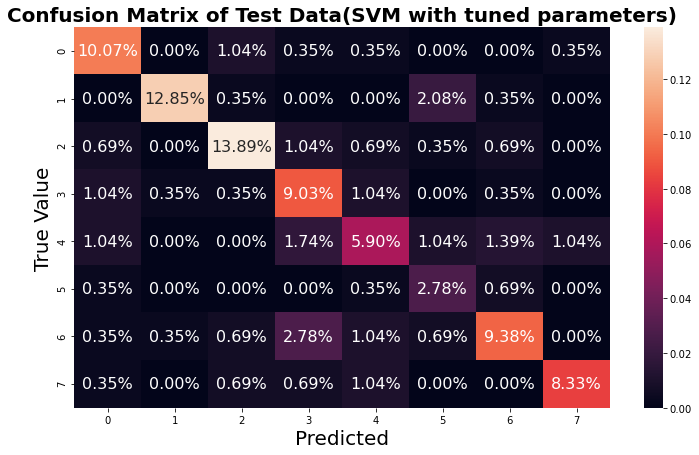

In [147]:
#Visualizing the confusion matrix of SVM model in test dataset

plt.figure(figsize=(12, 7))
sns.heatmap(cm_test/np.sum(cm_test), annot=True,fmt='.2%',annot_kws={"size": 16})
plt.title("Confusion Matrix of Test Data(SVM with tuned parameters)",size='20',weight='bold')
plt.xlabel("Predicted",size='20')
plt.ylabel("True Value",size='20')
plt.show()

In [23]:
df = pd.DataFrame({'Actual': y_test, 'Predicted':y_pred})
df

,Actual,Predicted
0,disgust,disgust
1,happy,happy
2,angry,surprised
3,neutral,disgust
4,angry,angry
...,...,...
283,calm,calm
284,angry,angry
285,angry,fearful
286,angry,angry


### Saving the model

In [24]:
import pickle
Pkl_Filename = "Emotion_Voice_Detection_Model.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(model, file)

### Accessing the model

In [25]:
with open(Pkl_Filename, 'rb') as file:  
    Emotion_Voice_Detection_Model= pickle.load(file)

Emotion_Voice_Detection_Model

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

## Testing self recorded voice

In [26]:
for f in tqdm(glob.glob(r'vinesh.wav')):
    
    f_name = os.path.basename(f)
    sig, rt = lr.load(f, sr=16000)
    th = 0.0005
    masking = sampling(sig,rt,th)
    
    wavfile.write(filename= r'vinesh.wav', rate = rt, data = sig[masking])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


In [27]:
file = 'vinesh.wav'
ans = []
new_feature = feature_extraction(file)
ans.append(new_feature)
ans = np.array(ans)

scaler = StandardScaler()
ans = scaler.fit_transform(ans)

y_pred_new = model.predict(ans)
y_pred_new

array(['angry'], dtype='<U9')